In [1]:
import numpy as np
from scipy.optimize import Bounds, LinearConstraint, minimize, LinearConstraint

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

The variance of the bifidelity variance estimator when $K=2$ is given by 
\begin{align}
    \mathbb{V}\mathrm{ar}[\hat{V}_{\mathrm{bf}}] &= \frac{1}{m_{1}} \left(\delta_{1} - \frac{m_{1} - 3}{m_{1} -1} \sigma_{1}^{4}\right)\\ &+ \alpha_{2}^2 \left( \frac{1}{m_{1}} (\delta_{2} - \frac{m_{1} - 3}{m_{1} -1} \sigma_{2}^{4}) -\frac{1}{m_{2}} (\delta_{2} - \frac{m_{2} -3}{m_{2}-1} \sigma_{2}^{4})\right)\\
    &+ 2 \alpha_{2} \left(\frac{1}{m_{2}}(q_{1, 2} \tau_{1} \tau_{2} + \frac{2}{m_{2}-1} \rho_{1, 2}^2 \sigma_{1}^2 \sigma_{2}^2) -\frac{1}{m_{1}}(q_{1, 2} \tau_{1}\tau_{2} + \frac{2}{m_{1}-1} \rho_{1, 2}^{2}\sigma_{1}^{2} \sigma_{2}^{2})\right).
\end{align}

In [3]:
# estimated quantities
w2 = 0.11
p = 1000
rho1 = 0.9997
sigma1 = 3.29
sigma2 = 3.25
delta1 = 492
delta2 = 475
q2 = 0.9997
tau12 = 19.34*19.06

In [4]:
def MSE(params):
    alpha2 = params[1]
    # restrain to integer
    m2 = params[0]
    # equality constraint 
    m1 = p - m2*w2
    # An objective can be formulated
    # term1 
    term1 = (1/m1) * (delta1 - ((m1-3)/(m1-1))*(sigma1**4))
    # term2 
    term2 = (alpha2**2) * (1/m1 * (delta2 - ((m1-3)/(m1-1))*(sigma2**4)) - 1/m2 * (delta2 - ((m2-3)/(m2-1))*(sigma2**4)))
    # term3
    term3 = (2*alpha2) * (1/m2 * (q2*tau12 + 2*((rho1*sigma1*sigma2)**2)/(m2-1))  - 1/m1 * (q2*tau12 + 2*((rho1*sigma1*sigma2)**2)/(m1-1))) 
    return term1 + term2 + term3

In [5]:
m_vec = np.floor(np.linspace(2, p/w2 - 200, 1000))
alpha2_vec = np.linspace(0, 2, 1000)

In [6]:
# solution matrix
mse_vals = np.zeros((len(m_vec), len(alpha2_vec)))
for ii in range(len(m_vec)):
    for jj in range(len(alpha2_vec)):
        mse_vals[ii, jj] = MSE(params=np.array([m_vec[ii], alpha2_vec[jj]]))

In [7]:
linear_constraint = LinearConstraint([[1, 0], [0, 1]], [2, 0], [p/w2 - 100, 2])
x0 = [0.8*p/w2, 1.5]

In [8]:
history_m2 = []
history_alpha2 = []
f_vec = []

def callback(x, y):
    history_m2.append(x[0])
    history_alpha2.append(x[1])
    f_vec.append(MSE(x))
    

res = minimize(MSE, x0, method="trust-constr", constraints=linear_constraint, callback=callback)

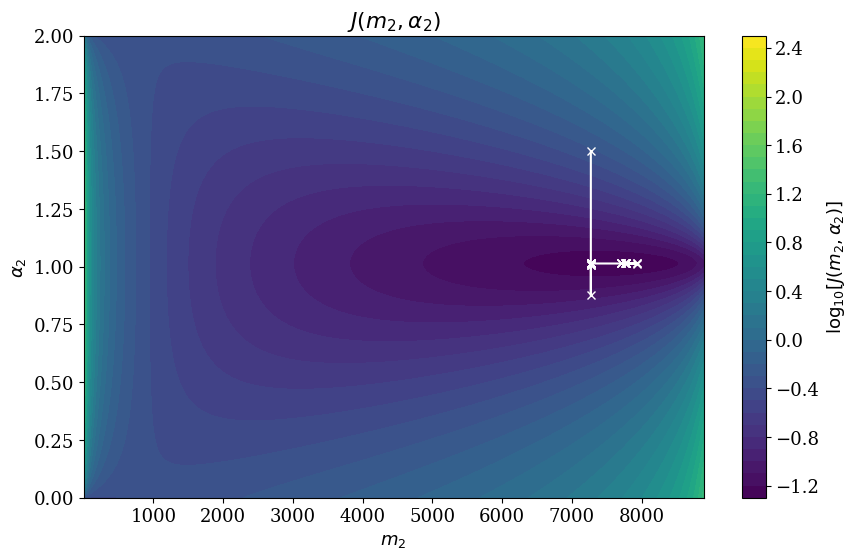

In [9]:
X, Y = np.meshgrid(m_vec, alpha2_vec)

fig, ax = plt.subplots(figsize=(10, 6))

cp = ax.contourf(X, Y, np.log10(mse_vals).T, levels=40)


ax.plot(history_m2, history_alpha2, "-x", c="white")
    
cbar = fig.colorbar(cp) 
cbar.ax.set_ylabel(r'$\log_{10}[J(m_{2},\alpha_{2})]$', rotation=90)
ax.set_title(r"$J(m_{2},\alpha_{2})$")
ax.set_xlabel(r'$m_{2}$')
ax.set_ylabel(r'$\alpha_{2}$')
plt.show()

In [10]:
index =  np.unravel_index(np.argmin(mse_vals), mse_vals.shape)
print("m2 = ", res["x"][0])
print("a2 =", res["x"][1])
print("m1 = ",  p - res["x"][0]*w2)
print("min MFMC = ", res["fun"])
print("MC = ", (1/p) * (delta1 - ((p-3)/(p-1))*sigma1**4))

m2 =  7770.899126941492
a2 = 1.0140113926231986
m1 =  145.20109603643584
min MFMC =  0.056242439659430765
MC =  0.37507341602845845


In [11]:
p_vec = np.floor(np.linspace(int(1e2), int(5e4), 10))
mse__p = np.ones(len(p_vec))*np.inf

for kk in range(len(p_vec)):
    # get p value
    p = p_vec[kk]
    # get possible m-values
    x0 = [0.8*p/w2, 1.5]
    linear_constraint = LinearConstraint([[1, 0], [0, 1]], [2, 0], [p/w2 - 100, 20])
    # optimize
    res = minimize(MSE, x0,  method="trust-constr", constraints=linear_constraint)
    # get minimum
    mse__p[kk] = np.min(res["fun"])

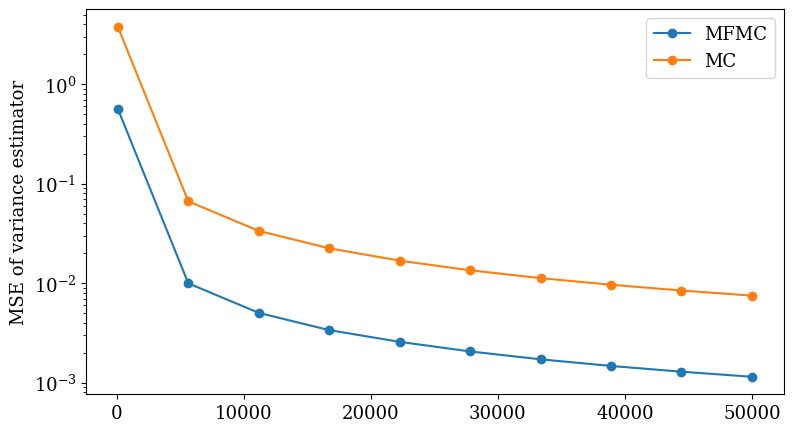

In [12]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(p_vec, mse__p, "-o", label="MFMC")
ax.plot(p_vec, (1/p_vec) * (delta1 - ((p_vec-3)/(p_vec-1))*sigma1**4),"-o",  label="MC")
ax.legend()
ax.set_ylabel("MSE of variance estimator")
ax.set_yscale("log")
#ax.set_xscale("log")